[View in Colaboratory](https://colab.research.google.com/github/youqad/Neurorobotics_Intent-Recognition/blob/master/TP_Intent_Recognition.ipynb)

# TP 4: Intent recognition

# *Exercise 1*: Automatic detection of speaker’s intention from supra-segmental features

The aim of this exercice is to develop a human feedback classifier : positive (approval) / negative (prohibition). This classifier might be used to teach robots and/or to guide
robot’s learning.

In [0]:
import urllib.request
import numpy as np
import pandas as pd
from google.colab import files as google_files

import itertools
import matplotlib.pyplot as plt

In [12]:
!pip install ggplot

import ggplot

    100% |████████████████████████████████| 2.2MB 8.3MB/s 


/usr/local/lib/python3.6/dist-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/usr/local/lib/python3.6/dist-packages/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
/usr/local/lib/python3.6/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [0]:
def list_from_URL(file_URL, function_applied=None):
  lines_bytes = urllib.request.urlopen(file_URL).readlines()
  lines = []

  for line in lines_bytes:
    line = line.decode("utf-8").rstrip()
    
    if function_applied is not None:
      line = function_applied(line)
    
    lines.append(line)
   
  return lines

def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    From: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## 1. Extraction of prosodic features ($f_0$ and energy)

In [0]:
# # /!\ NO NEED TO EXECUTE THIS CELL AGAIN !!!
# 
# 
# filenames = list_from_URL('https://raw.githubusercontent.com/youqad/Neurorobotics_Intent-Recognition/master/filenames.txt')
# filenames = list(set(filenames))
# 
# files = []
# indices = []
# 
# for file in filenames:
# 
#     URL_f0 = 'https://raw.githubusercontent.com/youqad/Neurorobotics_Intent-Recognition/master/data_files/{}.f0'.format(file)
#     file_dicts = [{key:val for key, val in zip(['time', 'f0'], map(float, l.split()))} for l in list_from_URL(URL_f0)]
# 
#     URL_en = 'https://raw.githubusercontent.com/youqad/Neurorobotics_Intent-Recognition/master/data_files/{}.en'.format(file)
#     for l, d in zip(list_from_URL(URL_en), file_dicts):
#       d["file"] = file
#       d["en"] = float(l.split()[1])
#       d["label"] = file[-2:]
# 
#     files.extend(file_dicts)
# 
# # How `files` looks like:
# # files = [ 
# #           {"file": "cy0001at", "time": 0.02, "f0": 0., "en": 0.},
# #           {"file": "cy0001at", "time": 1.28, "f0": 0., "en": 0.},
# #           ...
# #           {"file": "li1450at", "time": 0.02, "f0": 0., "en": 0.},
# #           {"file": "li1450at", "time": 1.56, "f0": 404., "en": 65.}
# #         ]
# 
# pd.DataFrame(files).to_csv('data.csv', encoding='utf-8', index=False) # To reuse it next time
# google_files.download('data.csv')

In [4]:
# loading training data
df = pd.read_csv('https://raw.githubusercontent.com/youqad/Neurorobotics_Intent-Recognition/master/data.csv').set_index('file')

df1 = df.loc[df['label'] != 'at']
df1.head()

,en,f0,label,time
file,,,,
li1377pw,0.0,0.0,pw,0.02
li1377pw,39.0,0.0,pw,0.04
li1377pw,40.0,0.0,pw,0.06
li1377pw,39.0,0.0,pw,0.08
li1377pw,39.0,0.0,pw,0.10


## 2. Extraction of functionals (statistics) : mean, maximum, range, variance, median, first quartile, third quartile, mean absolute of local derivate

In [5]:
print(df1.columns.values)

#df.groupby('file').mean().head()
#df1.groupby('file').max().head()
#df1.groupby('file').var().head()
#df1.groupby('file').median().head()
df1.groupby('file').quantile([.25, .75]).head()

['en' 'f0' 'label' 'time']


en     f0   time
file                              
cy0007pw 0.25  41.00    0.0  0.525
         0.75  66.00  189.5  1.535
cy0008pw 0.25  41.00    0.0  0.270
         0.75  64.50  192.0  0.770
cy0009pw 0.25  40.75    0.0  0.395

In [6]:
list_features  = ['mean', 
                  'max',
                  ('range', lambda x: max(x)-min(x)),
                  'var',
                  'median',
                  ('1st_quantile', lambda x: x.quantile(.25)),
                  ('3rd_quantile', lambda x: x.quantile(.75)),
                  ('mean_absolute_local_derivate', lambda x: abs(x.diff()).mean())
                 ]

df1.groupby('file')['f0','en'].agg(list_features).head()

f0                                                  \
                mean    max  range           var median 1st_quantile   
file                                                                   
cy0007pw   92.284314  257.0  257.0  10372.542128    0.0          0.0   
cy0008pw   78.431373  250.0  250.0   9930.090196    0.0          0.0   
cy0009pw   69.065789  243.0  243.0   8927.182281    0.0          0.0   
cy0010pw   29.196078  221.0  221.0   4696.178994    0.0          0.0   
cy0011pw  110.743590  230.0  230.0   9290.400932  172.0          0.0   

                                                           en              \
         3rd_quantile mean_absolute_local_derivate       mean   max range   
file                                                                        
cy0007pw       189.50                    13.683168  52.313725  71.0  71.0   
cy0008pw       192.00                    26.440000  47.725490  70.0  70.0   
cy0009pw       182.25                    12.853333  49.473684  74.0  74.0   
cy0010pw         0.00                    15.267327  46.049020  77.0  77.0   
cy0011pw       192.50                     7.506494  53.653846  71.0  71.0   

                                                       \
                 var median 1st_quantile 3rd_quantile   
file                                                    
cy0007pw  228.455057   52.0        41.00        66.00   
cy0008pw  321.963137   43.0        41.00        64.50   
cy0009pw  260.839298   42.0        40.75        66.00   
cy0010pw  165.789652   42.0        41.00        50.75   
cy0011pw  258.125375   62.0        41.25        66.00   

                                       
         mean_absolute_local_derivate  
file                                   
cy0007pw                     2.970297  
cy0008pw                     3.960000  
cy0009pw                     3.520000  
cy0010pw                     3.306931  
cy0011pw                     2.337662

## 3. Check functionals for both voiced (i.e. $f_0\neq 0$) and unvoiced segments. Which segments are suited for the approach ?

In [7]:
voiced = df1.loc[df1['f0']!=0].groupby('file')['f0','en'].agg(list_features)
voiced.head()

f0                                               \
                mean    max range         var median 1st_quantile   
file                                                                
cy0007pw  200.276596  257.0  90.0  675.987049  191.0       182.50   
cy0008pw  200.000000  250.0  83.0  538.421053  198.5       179.50   
cy0009pw  194.407407  243.0  77.0  446.943020  190.0       180.00   
cy0010pw  186.125000  221.0  67.0  465.316667  178.5       171.25   
cy0011pw  191.955556  230.0  66.0  314.816162  190.0       179.00   

                                                           en              \
         3rd_quantile mean_absolute_local_derivate       mean   max range   
file                                                                        
cy0007pw       213.00                     5.869565  65.914894  71.0  16.0   
cy0008pw       210.00                    10.368421  61.000000  70.0  70.0   
cy0009pw       209.00                     7.192308  67.333333  74.0  20.0   
cy0010pw       204.25                     6.466667  65.750000  77.0  25.0   
cy0011pw       204.00                     4.113636  65.288889  71.0  19.0   

                                                       \
                 var median 1st_quantile 3rd_quantile   
file                                                    
cy0007pw   17.775208   66.0         63.5        70.00   
cy0008pw  242.736842   66.0         61.5        68.00   
cy0009pw   17.923077   68.0         66.0        70.00   
cy0010pw   50.466667   64.0         62.0        70.75   
cy0011pw   14.710101   65.0         63.0        68.00   

                                       
         mean_absolute_local_derivate  
file                                   
cy0007pw                     1.652174  
cy0008pw                     5.842105  
cy0009pw                     2.884615  
cy0010pw                     4.000000  
cy0011pw                     0.954545

In [8]:
unvoiced = df1.loc[df1['f0']==0].groupby('file')['en'].agg(list_features)
unvoiced.head()

,mean,max,range,var,median,1st_quantile,3rd_quantile,mean_absolute_local_derivate
file,,,,,,,,
cy0007pw,40.690909,58.0,58.0,113.550842,41.0,40.5,43.5,3.740741
cy0008pw,39.161290,58.0,58.0,189.606452,42.0,41.0,43.0,5.200000
cy0009pw,39.632653,56.0,56.0,119.570578,41.0,40.0,42.0,3.625000
cy0010pw,42.383721,68.0,68.0,101.439261,41.0,40.0,43.0,3.105882
cy0011pw,37.787879,51.0,51.0,150.922348,41.0,40.0,42.0,4.062500


## 4. Build two databases by randomly extracting examples : Learning database ($60\%$) and Test database

In [0]:
# Question 3

## Explanation: A sound can be either voiced, like a vowel, or unvoiced, like a consonant. We want to see which of them contains more intention
 
## ps: change "data" by the correct name

def train_test(df=df1, train_percentage=.6, seed=1):
  
  voiced = df.loc[df['f0']!=0].groupby('file')['f0','en'].agg(list_features)
  unvoiced = df.loc[df['f0']==0].groupby('file')['en'].agg(list_features)

  X, Y = {}, {}

  X['voiced'], Y['voiced'] = {}, {}
  X['unvoiced'], Y['unvoiced'] = {}, {}


  X['voiced']['all'] = np.array(df.groupby('file')['f0','en'].agg(list_features))
  Y['voiced']['all'] = np.array(df.loc[df['f0']!=0].groupby(['file']).min().label.values)

  X['unvoiced']['all'] = np.array(unvoiced)
  Y['unvoiced']['all'] = np.array(df.loc[df['f0']==0].groupby(['file']).min().label.values)
  
  np.random.seed(seed)
  
  for type in ['voiced', 'unvoiced']:
    n = len(X[type]['all'])
    ind_rand = np.random.randint(n, size=int(train_percentage*n)) # random indices
    train_mask = np.zeros(n, dtype=bool)
    train_mask[ind_rand] = True
    X[type]['train'], X[type]['test'] = X[type]['all'][train_mask],  X[type]['all'][~train_mask]
    Y[type]['train'], Y[type]['test'] = Y[type]['all'][train_mask],  Y[type]['all'][~train_mask]
  
  return X, Y

X1, Y1 = train_test()

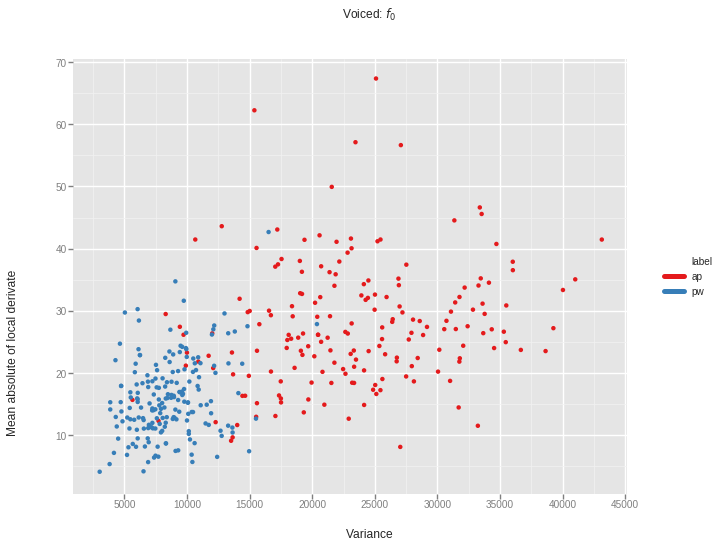

<ggplot: (8772619415223)>

In [45]:
col = ['mean', 'max', 'range', 'var', 'median', '1st_quantile', '3rd_quantile', 'mean_absolute_local_derivate']
col = ['f0_'+c for c in col]+['en_'+c for c in col]

voi = pd.DataFrame(X1['voiced']['all'], columns=col).assign(label=Y1['voiced']['all'])

ggplot.ggplot(voi, ggplot.aes(x='f0_var', y='f0_mean_absolute_local_derivate', color='label')) +\
    ggplot.geom_point() +\
    ggplot.scale_color_brewer(type='qual', palette='Set1') +\
    ggplot.xlab("Variance") + ggplot.ylab("Mean absolute of local derivate") + ggplot.ggtitle("Voiced: $f_0$")

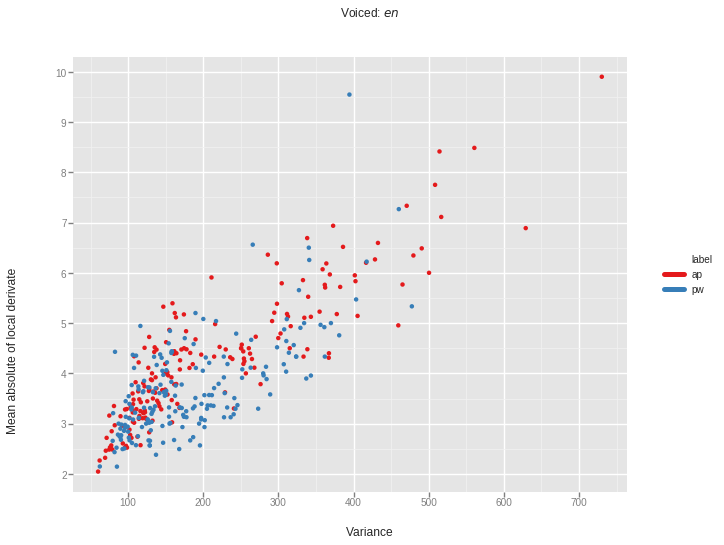

<ggplot: (8772619328376)>

In [47]:
col = ['mean', 'max', 'range', 'var', 'median', '1st_quantile', '3rd_quantile', 'mean_absolute_local_derivate']

unvoi = pd.DataFrame(X1['unvoiced']['all'], columns=col).assign(label=Y1['unvoiced']['all'])

ggplot.ggplot(unvoi, ggplot.aes(x='var', y='mean_absolute_local_derivate', color='label')) +\
    ggplot.geom_point() +\
    ggplot.scale_color_brewer(type='qual', palette='Set1') +\
    ggplot.xlab("Variance") + ggplot.ylab("Mean absolute of local derivate") + ggplot.ggtitle("Voiced: $en$")

## 5. Train a classifer (k-NN method)

In [32]:
# Scikit Learn's kNN classifier:
# Just to test, but we will implement it ourselves of course!
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

def sklearn_knn(k, X, Y):
  for type in ['voiced', 'unvoiced']:
    kNN = KNeighborsClassifier(n_neighbors=k)
    kNN.fit(X[type]['train'], Y[type]['train'])

    print("Accuracy score for {}: {:.2f}".format(type, accuracy_score(Y[type]['test'],
                                                                  kNN.predict(X[type]['test']))))
sklearn_knn(3, X1, Y1)

Accuracy score for voiced: 0.91
Accuracy score for unvoiced: 0.61


Normalized confusion matrix
[[0.92       0.08      ]
 [0.09473684 0.90526316]]


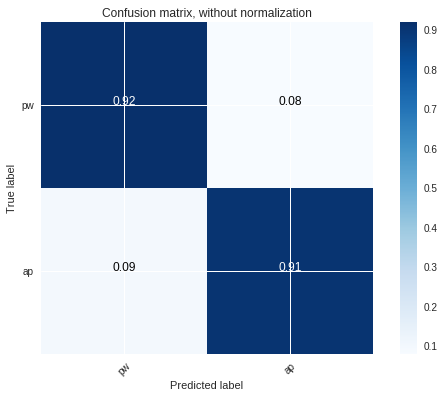

Normalized confusion matrix
[[0.48648649 0.51351351]
 [0.22727273 0.77272727]]


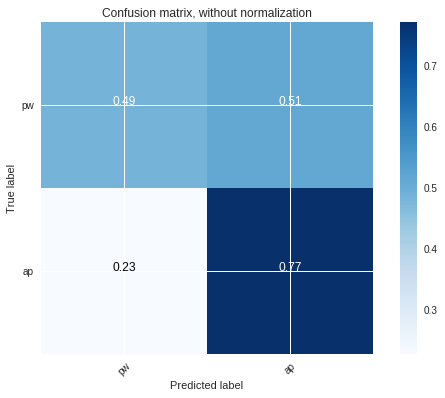

In [56]:
# Our own implementation!
from scipy.spatial.distance import cdist
from sklearn.metrics import confusion_matrix
from collections import Counter

def kNN(k, X, Y, labels=["pw", "ap"]):
    # auxiliary function: label prediction (by majority vote)
    # based on the nearest neighbors
    def predicted_label(ind_neighbors):
        label_neighbors = tuple(Y['train'][ind_neighbors])
        return Counter(label_neighbors).most_common(1)[0][0]
    
    # Pairwise distances between test and train data points
    dist_matrix = cdist(X['test'], X['train'], 'euclidean')
    y_predicted = []

    for i in range(len(X['test'])):
        ind_k_smallest = np.argpartition(dist_matrix[i, :], k)[:k]
        y_predicted.append(predicted_label(ind_k_smallest))
    
    # Confusion matrix: C[i, j] is the number of observations 
    # known to be in group i but predicted to be in group j
    return confusion_matrix(Y['test'], np.array(y_predicted), labels=labels)

plt.figure()
cm = kNN(3, X1['voiced'], Y1['voiced'])
plot_confusion_matrix(cm, classes=["pw", "ap"],
                      title='Confusion matrix, without normalization')
plt.show()

cm2 = kNN(3, X1['unvoiced'], Y1['unvoiced'])
plot_confusion_matrix(cm2, classes=["pw", "ap"],
                      title='Confusion matrix, without normalization')
plt.show()

# *Exercice 2*: Detection of multiple intents

We consider the following intents : "Approval", "Prohibition" and "Attention"

## 1. Extract the prosodic features ($f_0$ and energy) and their functionals

In [34]:
# Easy-peasy! All the work has been done before: all we have to do now is to use 
# the DataFrame `df` instead of `df1`

df.groupby('file')['f0','en'].agg(list_features).head()

f0                                                  \
                mean    max  range           var median 1st_quantile   
file                                                                   
cy0001at  110.609375  402.0  402.0  27607.511657    0.0          0.0   
cy0002at  105.640449  430.0  430.0  27108.528345    0.0          0.0   
cy0005at  110.609375  402.0  402.0  27607.511657    0.0          0.0   
cy0006at  105.640449  430.0  430.0  27108.528345    0.0          0.0   
cy0007pw   92.284314  257.0  257.0  10372.542128    0.0          0.0   

                                                           en              \
         3rd_quantile mean_absolute_local_derivate       mean   max range   
file                                                                        
cy0001at        331.0                    23.777778  47.296875  73.0  73.0   
cy0002at        251.0                    15.636364  47.337079  76.0  76.0   
cy0005at        331.0                    23.777778  47.296875  73.0  73.0   
cy0006at        251.0                    15.636364  47.337079  76.0  76.0   
cy0007pw        189.5                    13.683168  52.313725  71.0  71.0   

                                                       \
                 var median 1st_quantile 3rd_quantile   
file                                                    
cy0001at  327.323165   41.5         40.0         67.0   
cy0002at  269.112360   41.0         40.0         62.0   
cy0005at  327.323165   41.5         40.0         67.0   
cy0006at  269.112360   41.0         40.0         62.0   
cy0007pw  228.455057   52.0         41.0         66.0   

                                       
         mean_absolute_local_derivate  
file                                   
cy0001at                     3.809524  
cy0002at                     3.272727  
cy0005at                     3.809524  
cy0006at                     3.272727  
cy0007pw                     2.970297

## 2. Develop a classifier for these three classes

In [0]:
X, Y = train_test(df=df)

In [38]:
sklearn_knn(3, X, Y)

Accuracy score for voiced: 0.74
Accuracy score for unvoiced: 0.45


Normalized confusion matrix
[[0.86138614 0.08910891 0.04950495]
 [0.11111111 0.61111111 0.27777778]
 [0.02325581 0.30232558 0.6744186 ]]


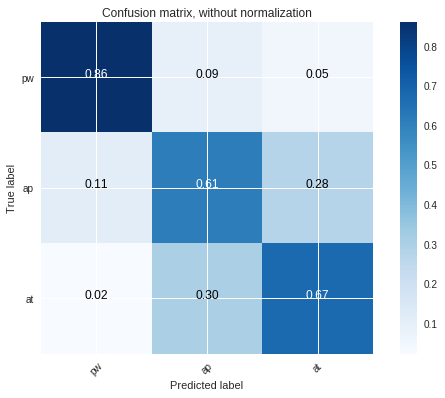

Normalized confusion matrix
[[0.51401869 0.28971963 0.19626168]
 [0.23529412 0.45098039 0.31372549]
 [0.22826087 0.40217391 0.36956522]]


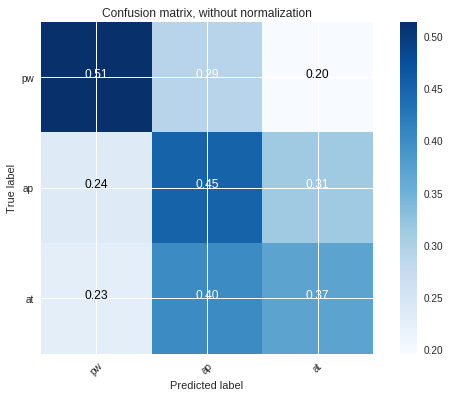

In [57]:
plt.figure()
cm = kNN(3, X['voiced'], Y['voiced'], labels=["pw", "ap", "at"])
plot_confusion_matrix(cm, classes=["pw", "ap", "at"],
                      title='Confusion matrix, without normalization')
plt.show()

cm2 = kNN(3, X['unvoiced'], Y['unvoiced'], labels=["pw", "ap", "at"])
plot_confusion_matrix(cm2, classes=["pw", "ap", "at"],
                      title='Confusion matrix, without normalization')
plt.show()